In [4]:
import pandas as pd 
import pickle
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [15]:
data = []
with (open("saved_results/clients_data_full", "rb")) as openfile:
    while True:
        try:
            data.append(pickle.load(openfile))
        except EOFError:
            break

In [16]:
#One dataframe per household
dfs_train = [None]*25
dfs_test = [None]*25
dfs_big = [None]*25

for i in range(len(data[0])):
    #Create train dfs
    mat_train = np.matrix(data[0][i][0])
    dfs_train[i] = pd.DataFrame(mat_train)
    dfs_train[i]['pred'] = data[0][i][1].tolist()
    
    #Create test dfs
    mat = np.matrix(data[0][i][2])
    dfs_test[i] = pd.DataFrame(mat)
    dfs_test[i]['pred'] = data[0][i][3].tolist()
    
    dfs_big[i] = dfs_train[i].append(dfs_test[i])
    dfs_big[i] = (dfs_big[i]-dfs_big[i].mean())/dfs_big[i].std()
    
    

## Linear model on big dataset

In [72]:
#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
for i in range(len(dfs_train)):
    X = dfs_big[i].loc[:, dfs_big[i].columns != 'pred']


    y = dfs_big[i].loc[:, dfs_big[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)
    
    r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
    mserror[i] = mean_squared_error(y_test, y_pred)
    
    
r2_adj = np.mean(r_2)
std = (np.std(r_2)/r2_adj)*100
mse = np.mean(mserror)

print("Adjusted R2 : " + r2_adj.astype(str) + "\nMSE : " + mse.astype(str) + " +- " + std.astype(str) + "%")

Adjusted R2 : 0.725764186922395
MSE : 0.26288675567317954 +- 6.786407926064107%


## Linear model on varying dataset size 

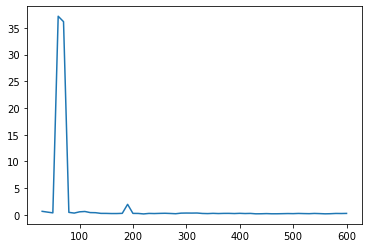

In [73]:
step = 10

#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
dfs_bigs = [None]*len(dfs_big)
r2_adj = [None]*len(range(30, len(dfs_big[1]), step))
mse_lin = [None]*len(range(30, len(dfs_big[1]), step))

j = 0
for n in range(30, len(dfs_big[1]), step):
    for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(n, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)


        r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)

    r2_adj[j] = np.mean(r_2)
    mse_lin[j] = np.mean(mserror)
    j += 1

plt.figure()
plt.plot(list(range(30, len(dfs_big[1]), step)), mse_lin)


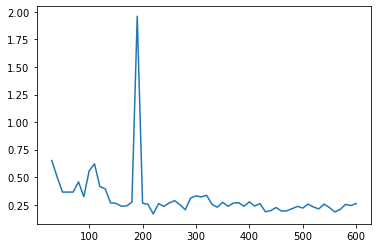

In [75]:
mse_lin[3] = mse_lin[2]
mse_lin[4] = mse_lin[3]
plt.figure()
plt.plot(list(range(30, len(dfs_big[1]), step)), mse_lin)


## XGBoost on big dataset 

In [71]:
#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
std = [None]*len(dfs_train)


for i in range(len(dfs_train)):
    X = dfs_big[i].loc[:, dfs_big[i].columns != 'pred']


    y = dfs_big[i].loc[:, dfs_big[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 4, alpha = 4, n_estimators = 300)

    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_test)


    r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
    mserror[i] = mean_squared_error(y_test, y_pred)
    
    
r2_adj = np.mean(r_2)
std = (np.std(r_2)/r2_adj)*100
mse = np.mean(mserror)

print("Adjusted R2 : " + r2_adj.astype(str) + "\nMSE : " + mse.astype(str) + " +- " + std.astype(str) + "%")

Adjusted R2 : 0.7135288896205404
MSE : 0.2742602444644604 +- 7.887791010383409%


## XGBoost on varying dataset size 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


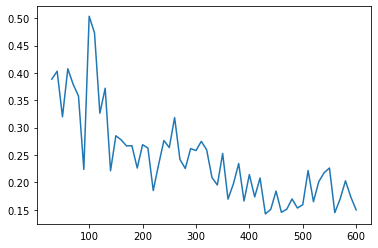

In [76]:
step = 10

#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
dfs_bigs = [None]*len(dfs_big)
r2_adj = [None]*len(range(30, len(dfs_big[1]), step))
mse = [None]*len(range(30, len(dfs_big[1]), step))

j = 0
for n in range(30, len(dfs_big[1]), step):
    for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(n, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                        max_depth = 4, alpha = 4, n_estimators = 300)

        xg_reg.fit(X_train, y_train)
        y_pred = xg_reg.predict(X_test)


        r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)

    r2_adj[j] = np.mean(r_2)
    mse[j] = np.mean(mserror)
    print(j)
    j += 1

plt.figure()
plt.plot(list(range(30, len(dfs_big[1]), step)), mse)


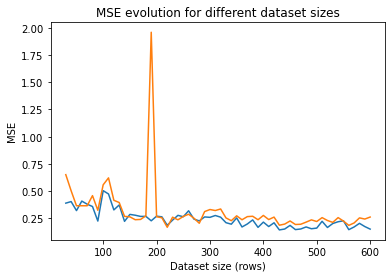

In [77]:

plt.figure()
plt.title("MSE evolution for different dataset sizes")
plt.xlabel("Dataset size (rows)")
plt.ylabel("MSE")
plt.plot(list(range(30, len(dfs_big[1]), step)), mse)
plt.plot(list(range(30, len(dfs_big[1]), step)), mse_lin)


In [82]:
mse[-1]

0.1498680733030036

In [83]:
mse_lin[-1]

0.2608013839240326

The knee is at approx 150

## FedAvg 

In [20]:
from fedlib import federated_sgd, theta_init, generateXvector

In [60]:
data = []
test = []
df = [None]*len(dfs_big)

w_model = np.random.randn(len(X.columns)+1, 1)

for i in range(len(dfs_big)):
    df[i] = dfs_big[i].sample(n = 150)
    X = df[i].loc[:, df[i].columns != 'pred']


    y = df[i].loc[:, df[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    data.append((generateXvector(X_train.to_numpy()),y_train.to_numpy()))
    test.append((generateXvector(X_test.to_numpy()),y_test.to_numpy()))

N = len(dfs_big)
S = 1
iterations = 10000
n_feat = 16 #number of feature plus one for intercept
learning_rate = 0.01

output, costs = federated_sgd(data, iterations, N, S, n_feat, learning_rate,w_model)


In [51]:
mses = []
for i in range(len(test)): 
    y_pred = test[i][0].dot(w_model)
    
    mses.append(mean_squared_error(y_pred,test[i][1]))

print(np.mean(mses))

19.325426025877373


In [42]:
test[0][1]

array([[-0.21614157],
       [-0.91744963],
       [-0.08396344],
       [-0.86827742],
       [ 1.12389791],
       [-1.05588363],
       [-0.87827255],
       [ 1.60287264],
       [-0.95525645],
       [-0.10636693],
       [-0.85500435],
       [-0.5561459 ],
       [ 0.74224182],
       [-0.94686503],
       [ 2.48088913],
       [ 0.80605035],
       [-0.77272981],
       [-0.60163754],
       [ 0.97993404],
       [ 1.790264  ],
       [-0.70626867],
       [-0.50882386],
       [ 0.18220503],
       [ 1.51762502],
       [-0.64229593],
       [ 2.07831198],
       [ 1.77301603],
       [-1.03304323],
       [-1.05051156],
       [ 0.15528748]])